# A Convolutional Neural Netwrok (CNN) for Binary Image Classification: Human or Anmial

### Importing the libraries

In [8]:
#installation of dependencies compatible with tf 2.10.0
# !pip install --no-cache-dir scipy==1.9.3 opencv-python pillow h5py==3.7.0 matplotlib seaborn

In [9]:
import os
# Suppress TensorFlow logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppresses INFO (1), WARNING (2), and ERROR (3)

# Import core libraries for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import essential data handling libraries
import numpy as np
import pandas as pd
import shutil
import random

# Import image processing libraries
from PIL import Image  # Pillow for handling image files
import PIL

# Data visualization & analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for system & performance optimization
import h5py  # Model storage and checkpointing
import time  # Measuring training duration
import gc  # Garbage collection for memory optimization

In [10]:
tf.__version__

'2.18.0'

## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [11]:
# We define our dataset paths based on our directory structure
base_dir = "/home/locutus/Downloads/CNN_Project_Group_17/dataset"
train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/val"
test_dir  = f"{base_dir}/test"

# Next we apply Feature Scaling + Data Augmentation to our Training Set (to avoid overfitting)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary')


Found 20480 images belonging to 2 classes.


### Preprocessing the Validation Set

In [12]:
# Our Validation set only requires feature scaling (no augmentation: keep it real)
val_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_datagen.flow_from_directory(val_dir,
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=False)


Found 4388 images belonging to 2 classes.


### Preprocessing the Test Set

In [13]:
# Like our Validation set our Test Set also only requires feature scaling (no augmentation: keep it real)
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False)

print("Data preprocessing complete. Training, validation, and test sets are ready!")

Found 4390 images belonging to 2 classes.
Data preprocessing complete. Training, validation, and test sets are ready!


### Visual Representation of our Data Distribution

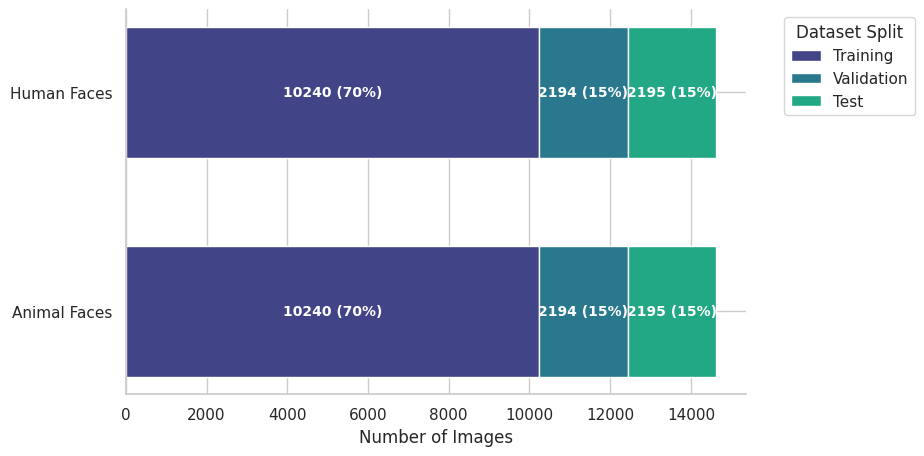

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create df for Seaborn
data = {
    "Category": ["Animal Faces", "Human Faces"],
    "Training": [10240, 10240],
    "Validation": [2194, 2194],
    "Test": [2195, 2195]
}

df = pd.DataFrame(data)

# define colors using viridis
colors = sns.color_palette("viridis", 4)

# set style
sns.set_theme(style="whitegrid")

# plot settings
fig, ax = plt.subplots(figsize=(8, 5))
bar_height = 0.6

# stacking bars manually using Matplotlib
bottom_values = [0, 0]

for i, split in enumerate(["Training", "Validation", "Test"]):
    bars = ax.barh(df["Category"], df[split], bar_height, left=bottom_values, color=colors[i], label=split)

    # add labels inside each section
    for bar, j in zip(bars, range(len(df["Category"]))):
        val = df[split][j]
        percent = val / sum(df.iloc[j, 1:]) * 100
        ax.text(bottom_values[j] + val / 2, j, f"{val} ({percent:.0f}%)", ha="center", va="center", 
                color="white", fontsize=10, fontweight="bold")
    
    # update bottom values for stacking
    bottom_values = [bottom_values[j] + df[split][j] for j in range(len(df["Category"]))]

# labels
ax.set_xlabel("Number of Images") 
ax.legend(title="Dataset Split", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.savefig('datasplit.png', format='png')

plt.show()

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Created a helper function to plot class distribution for "animals" and "humans"
# def plot_class_distribution(dataset, dataset_name):
#     # dataset.class_indices is a dict, e.g., {'animal': 0, 'human': 1}
#     # dataset.classes is a list of numeric labels, e.g., [0, 1, 0, ...]
#     class_indices = dataset.class_indices
#     # Created an inverse mapping from numeric label to class name (e.g., {0: 'animal', 1: 'human'})
#     inv_map = {v: k for k, v in class_indices.items()}
#     # Converted numeric classes to their string names
#     labels = [inv_map[x] for x in dataset.classes]

#     # Created a DataFrame for plotting
#     df = pd.DataFrame({'Class': labels})

#     plt.figure(figsize=(6, 4))
#     # Used 'Class' for both x and which ensures proper coloring for "animal" and "human"
#     ax = sns.countplot(x='Class', data=df, palette='Set2', hue='Class')
#     plt.title(f'{dataset_name} Class Distribution')
#     plt.xlabel('Classes')
#     plt.ylabel('Number of Images')
#     plt.xticks(rotation=45)

#     # Annotated each bar with the count value
#     for p in ax.patches:
#         count = p.get_height()
#         x = p.get_x() + p.get_width() / 2
#         y = p.get_height()
#         ax.annotate(f'{int(count)}', (x, y), ha='center', va='bottom', fontsize=10)

#     plt.legend([], [], frameon=False)  # Removed the duplicate legend entries
#     plt.tight_layout()
#     plt.show()

# # Finally, plot class distribution for the training, validation, and test sets
# plot_class_distribution(training_set, 'Training Set')
# plot_class_distribution(validation_set, 'Validation Set')
# plot_class_distribution(test_set, 'Test Set')

## Part 2 - Building the CNN

### Step 1 - Initialising the CNN

In [16]:
cnn = keras.models.Sequential()

# Here we added the input layer explicitly
cnn.add(keras.layers.Input(shape=(64, 64, 3))) # Input layer for images (64x64 pixels, 3 color channels)

In [17]:
#colored image in RGB, it's 64x64 as defined above, so it's 64x64x3
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))


### Step 2 - Pooling

In [18]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))  # pool_size should be a tuple (height, width)


#### Adding a second convolutional layer

In [19]:
# Here we apply our second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

# Here we apply a max pooling layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))  # pool_size is the dimension of the pooling matrix


### Step 3 - Flattening

In [20]:
# Here we flatten the layer
cnn.add(tf.keras.layers.Flatten())


### Step 4 - Fully Connected Dense Layer

In [21]:
# Here is our fully connected layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu')) #number of hidden neurons

### Step 5 - We addeded a Dropout Layer for Regularization

In [22]:
# Our Dropout Layer
cnn.add(tf.keras.layers.Dropout(0.5))  # 50% dropout to regularize the model


I0000 00:00:1740715639.120468  174701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 700 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


### Step 6 - Output Layer

In [23]:
# Our Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification:(Human or Animal)


## Part 3 - Training the CNN

### Compiling the CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Define dynamic F1Score metric using Precision and Recall
class DynamicF1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(DynamicF1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision(name="precision")
        self.recall = Recall(name="recall")

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Define CNN model
cnn = Sequential([
    InputLayer(shape=(64, 64, 3)),  

    # Conv1 with filter options
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Conv2 with filter options
    Conv2D(filters=96, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten layer
    Flatten(),

    # Fully connected layer
    Dense(units=192, activation='relu'),
    Dropout(0.3),  

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), DynamicF1Score()]
)

### Training the CNN on the Training set and validate it using our Validation Set

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs

#define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# We are training with EarlyStopping(as suggested)
history = cnn.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/home/locutus/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740715644.627932  175270 service.cc:148] XLA service 0x78fec8004cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740715644.627952  175270 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
I0000 00:00:1740715644.776938  175270 cuda_dnn.cc:529] Loaded cuDNN version 90700


  3/640 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.6562 - f1_score: 0.7412 - loss: 0.8134 - precision: 0.7104 - recall: 0.7759

I0000 00:00:1740715645.794951  175270 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/640 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.8275 - f1_score: 0.8321 - loss: 0.7708 - precision: 0.8303 - recall: 0.8340  

/home/locutus/tf_env/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


640/640 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.8847 - f1_score: 0.8866 - loss: 0.4412 - precision: 0.8871 - recall: 0.8861 - val_accuracy: 0.9537 - val_f1_score: 0.9520 - val_loss: 0.1194 - val_precision: 0.9887 - val_recall: 0.9180
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - accuracy: 0.9617 - f1_score: 0.9612 - loss: 0.1083 - precision: 0.9612 - recall: 0.9611 - val_accuracy: 0.8589 - val_f1_score: 0.8369 - val_loss: 0.4111 - val_precision: 0.9919 - val_recall: 0.7238
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 60s 94ms/step - accuracy: 0.9736 - f1_score: 0.9738 - loss: 0.0716 - precision: 0.9737 - recall: 0.9740 - val_accuracy: 0.9282 - val_f1_score: 0.9329 - val_loss: 0.2075 - val_precision: 0.8763 - val_recall: 0.9973
Epoch 4/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 60s 94ms/step - accuracy: 0.9823 - f1_score: 0.9822 - loss: 0.0507 - precision: 0.9825 - recall: 0.9821 - val_accuracy: 0.9193 - val_f1_score: 0.9233 - val_loss: 0.2658 - val_precision: 0.8799 - val_recall: 0.

## Part 4 - Assessment of Training with Visualization

### Validation Loss and Accuracy
Here we visualize our Training and Validation Loss:(Checking for Overfitting) and Our Training and Validation Accuracy


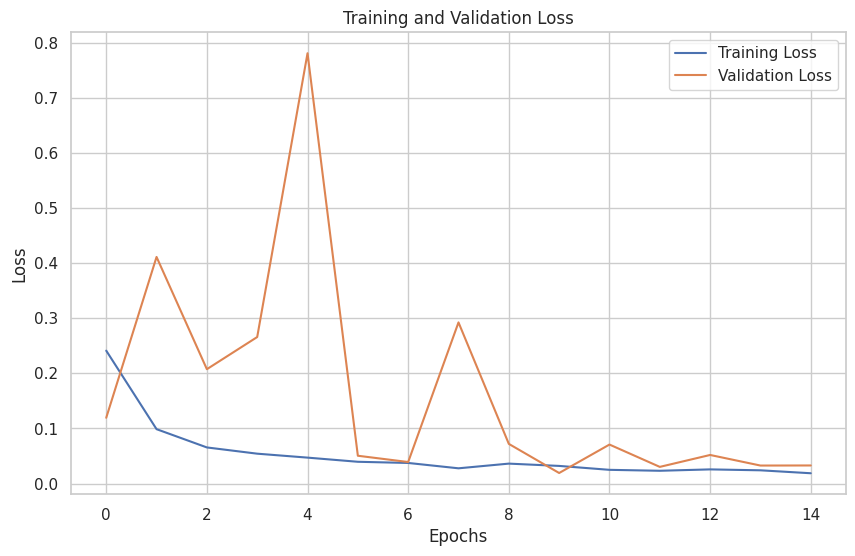

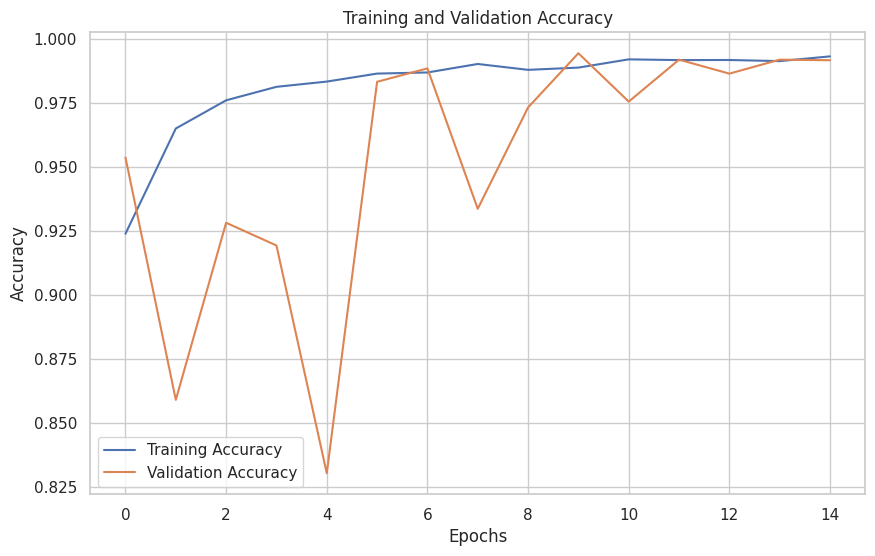

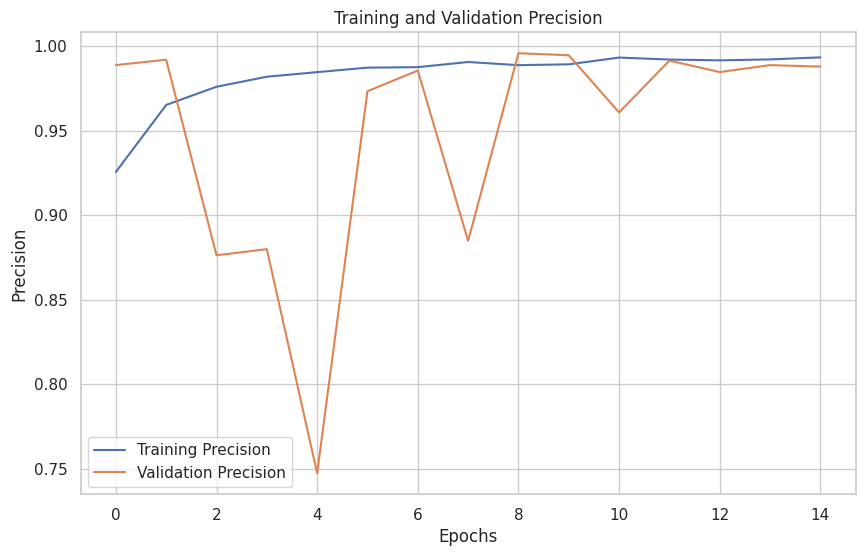

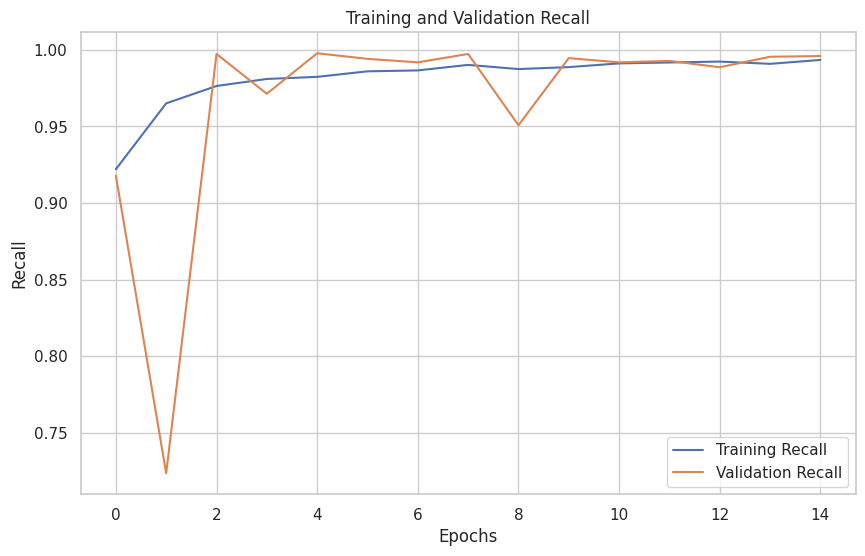

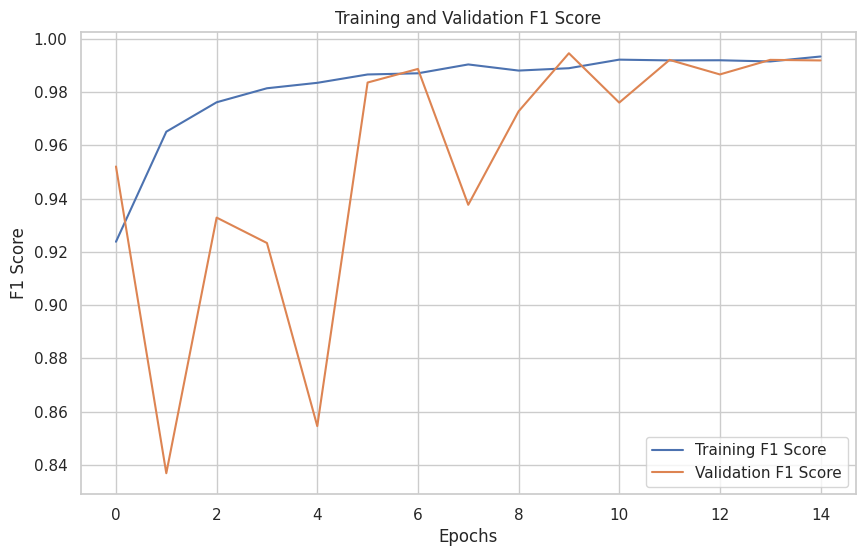

In [26]:
import matplotlib.pyplot as plt

# Here we plot our Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('TrainValLoss1.png', format='png')
plt.show()

# Here we plot our  Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('TrainValAcc1.png', format='png')
plt.show()

# Here we plot our Training & Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('TrainValPrecision1.png', format='png')
plt.show()

# Here we plot our Training & Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.savefig('TrainValRecall1.png', format='png')
plt.show()

# Here we plot out Training & Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('TrainValF1Score1.png', format='png')
plt.show()


### Metrics on the Validation Set

In [27]:
# We evaluate the model on the validation set
val_results = cnn.evaluate(validation_set)

# Here we unpack the results dynamically
val_metrics = dict(zip(cnn.metrics_names, val_results))

# Print all validation metrics
for metric, value in val_metrics.items():
    print(f"Val {metric.capitalize()}: {value:.4f}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9941 - f1_score: 0.5021 - loss: 0.0254 - precision: 0.4967 - recall: 0.5088            
Val Loss: 0.0192
Val Compile_metrics: 0.9945


### Confusion Matrix

138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step


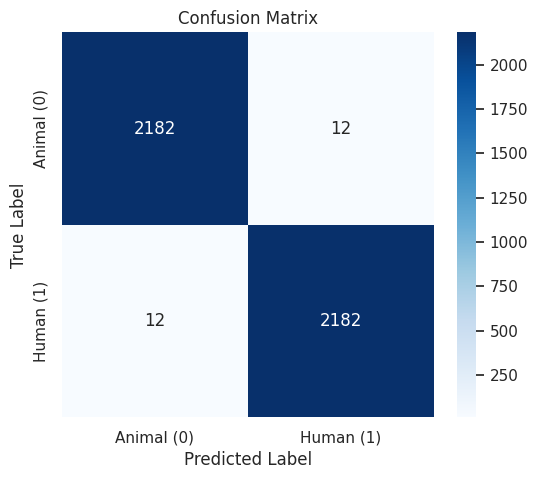

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2194
           1       0.99      0.99      0.99      2194

    accuracy                           0.99      4388
   macro avg       0.99      0.99      0.99      4388
weighted avg       0.99      0.99      0.99      4388



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Here we got out  True Labels from the Validation Set
y_true = validation_set.classes

# Next we predicted on the Validation Set
y_pred_prob = cnn.predict(validation_set)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Here we generate a Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_names = ['Animal (0)', 'Human (1)']

# Next we plot our Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('CM.png', format='png')
plt.show()


# Print Classification Report
print(classification_report(y_true, y_pred))

### ROC Curve and AUC

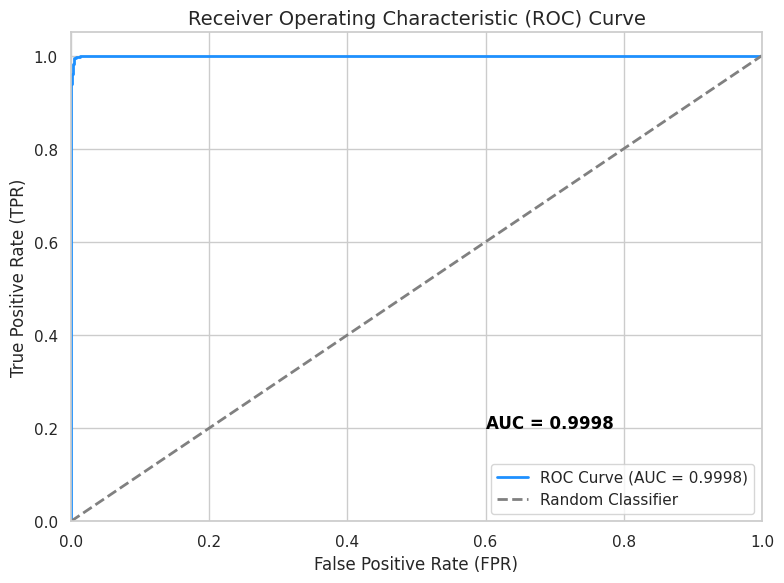

Area Under Curve (AUC): 0.9998


In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Here we compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Here we compute AUC score
roc_auc = auc(fpr, tpr)

# Next we plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')

# Customized axes limits for better readsbiltiy
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title for presentation
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)

# Here we display the AUC score inside the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}', fontsize=12, color='black', weight='bold')

# Here we display grid, legend, and save our plot
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('Improved_ROC.png', format='png')
plt.show()

# Print AUC Score
print(f"Area Under Curve (AUC): {roc_auc:.4f}")

### Here a scatter plot is used to asses overconfidence with predicted probabilities of y.

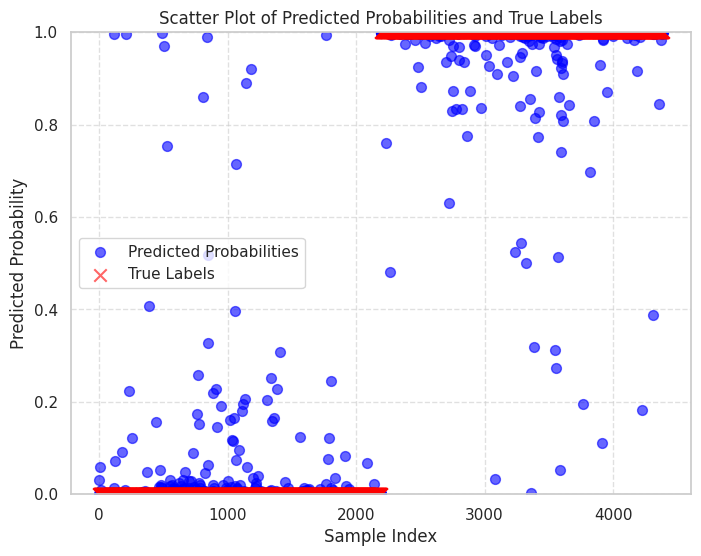

In [30]:
# Scatter plot of predicted probabilities
plt.figure(figsize=(8, 6))

# Scatter for predicted probabilities
plt.scatter(range(len(y_pred_prob)), y_pred_prob, alpha=0.6, label="Predicted Probabilities", color="blue", s=50)

# Overlay the true labels
plt.scatter(range(len(y_true)), y_true, alpha=0.6, label="True Labels", color="red", marker="x", s=80)

# Set axis limits for clarity (0 to 1 for predicted probabilities)
plt.ylim(0, 1)

# Labeling axes and title
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Scatter Plot of Predicted Probabilities and True Labels")

# Here we show gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Added a legend
plt.legend()

# Save and show the plot
plt.savefig('Improved_Scatter.png', format='png')
plt.show()


## Part 5 - Evaluation on the Test set

In [31]:
# We evaluate the model on the test set
test_results = cnn.evaluate(test_set)

# Here we unpack the results dynamically
test_metrics = dict(zip(cnn.metrics_names, test_results))

# Then we print all test metrics
for metric, value in test_metrics.items():
    print(f"Test {metric.capitalize()}: {value:.4f}")



  4/138 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9954 - f1_score: 0.0000e+00 - loss: 0.0167 - precision: 0.0000e+00 - recall: 0.0000e+00    

/home/locutus/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/138 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9899 - f1_score: 0.3597 - loss: 0.0278 - precision: 0.3496 - recall: 0.3735            

/home/locutus/tf_env/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9900 - f1_score: 0.4956 - loss: 0.0274 - precision: 0.4873 - recall: 0.5067
Test Loss: 0.0249
Test Compile_metrics: 0.9907


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Accuracy: 99.07%
Incorrect Accuracy: 0.93%


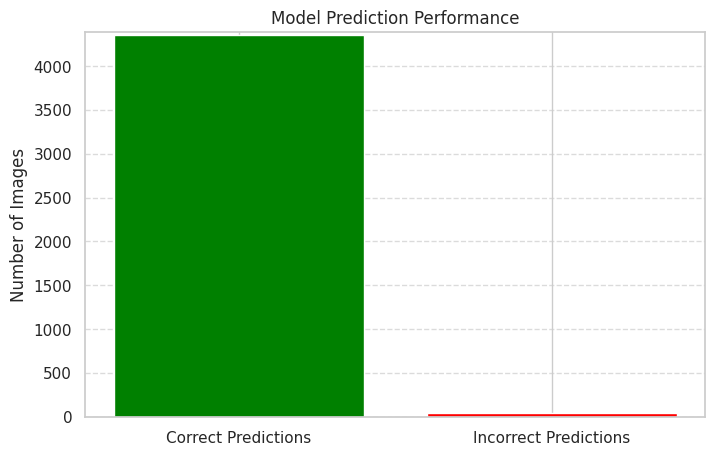

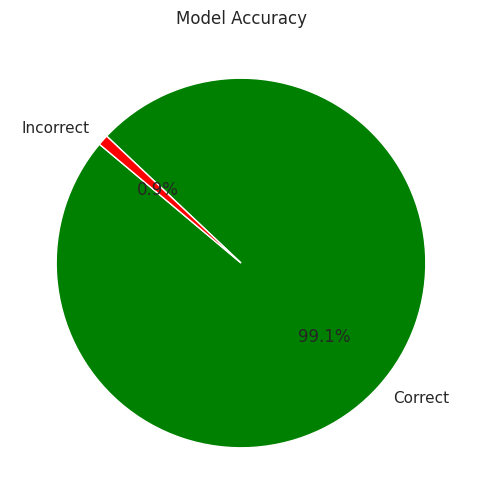

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Here we get true labels from the test set
y_true = test_set.classes

# Next we get the predictions and ensure they are binary (0 or 1)
y_pred = (cnn.predict(test_set, batch_size=32) > 0.5).astype(int)

# Flatten y_pred to match y_true shape
y_pred = y_pred.flatten()

# Here we calculate correct and incorrect predictions
correct_predictions = np.sum(y_pred == y_true)
incorrect_predictions = np.sum(y_pred != y_true)

# This computes Accuracy and Incorrect Accuracy
accuracy = (correct_predictions / len(y_true)) * 100
incorrect_accuracy = (incorrect_predictions / len(y_true)) * 100

# We ensure accuracy values remain between 0 and 100
accuracy = max(0, min(accuracy, 100))
incorrect_accuracy = max(0, min(incorrect_accuracy, 100))

# Print results for debugging
print(f"Accuracy: {accuracy:.2f}%")
print(f"Incorrect Accuracy: {incorrect_accuracy:.2f}%")

# Bar Chart: Correct vs Incorrect Predictions**
plt.figure(figsize=(8, 5))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [correct_predictions, incorrect_predictions],
        color=['green', 'red'])
plt.title('Model Prediction Performance')
plt.ylabel('Number of Images')
plt.ylim(0, len(y_true))  # Ensure the y-axis limit is set correctly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('barchart1.png', format='png')
plt.show()


# Pie Chart: Accuracy Distribution**
plt.figure(figsize=(6, 6))
plt.pie([correct_predictions, incorrect_predictions],
        labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%',
        colors=['green', 'red'],
        startangle=140)
plt.title('Model Accuracy')
plt.savefig('piechart.png', format='png')
plt.show()


## Part 6 - Making a Single Prediction
There are two images in a folder labelled "single_prediction." Here we test the model on both.  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


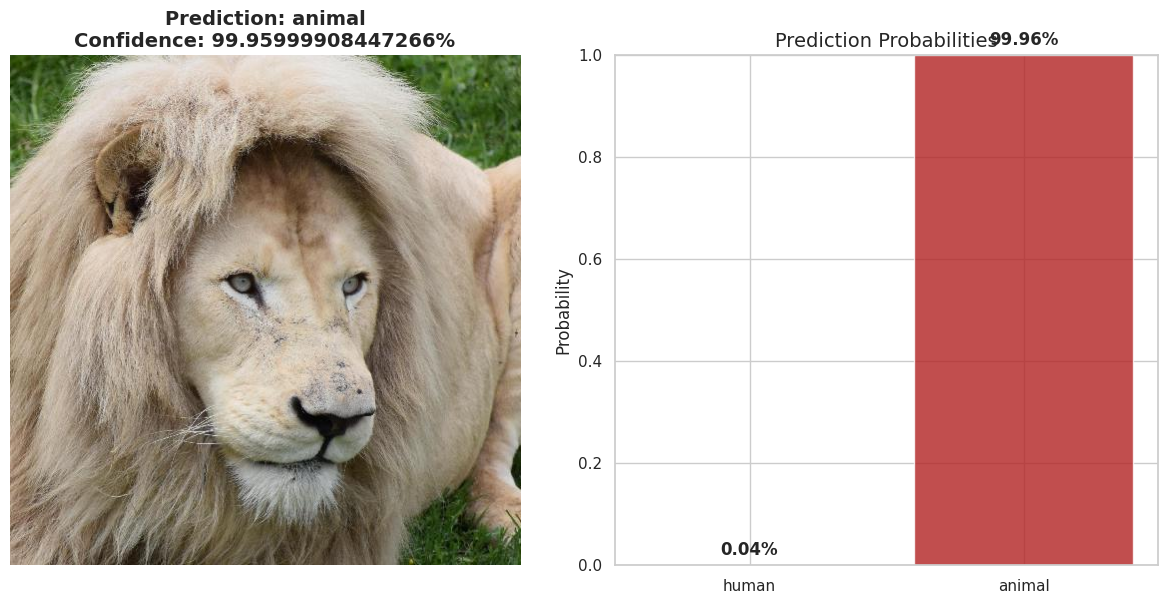

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = '/home/locutus/Downloads/CNN_Project_Group_17/dataset/single_prediction/human_or_animal_1.jpg'
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
result = cnn.predict(img_array)

# For binary classification with a sigmoid output:
# result[0][0] is the probability for 'human'
# and (1 - result[0][0]) is the probability for 'animal'
human_prob = result[0][0]
animal_prob = 1 - human_prob

# Determine prediction and confidence
prediction = 'human' if human_prob >= 0.5 else 'animal'
confidence = human_prob if human_prob >= 0.5 else animal_prob
confidence_percent = round(confidence * 100, 2)

# Create a figure with two subplots: one for the image and one for a bar chart
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Display the image with the prediction label and confidence
axs[0].imshow(image.load_img(img_path))
axs[0].axis('off')
axs[0].set_title(f'Prediction: {prediction}\nConfidence: {confidence_percent}%',
                 fontsize=14, fontweight='bold')

# Right subplot: Bar chart of predicted probabilities for each class
classes = ['human', 'animal']
probs = [human_prob, animal_prob]
colors = ['royalblue', 'firebrick']

bars = axs[1].bar(classes, probs, color=colors, alpha=0.8)
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Probability', fontsize=12)
axs[1].set_title('Prediction Probabilities', fontsize=14)

# Annotate each bar with the probability percentage
for bar, prob in zip(bars, probs):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob*100:.2f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Improved_Prediction.png', format='png')
plt.show()


In [34]:
print(prediction)

animal


Here we make a single prediction on the other image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


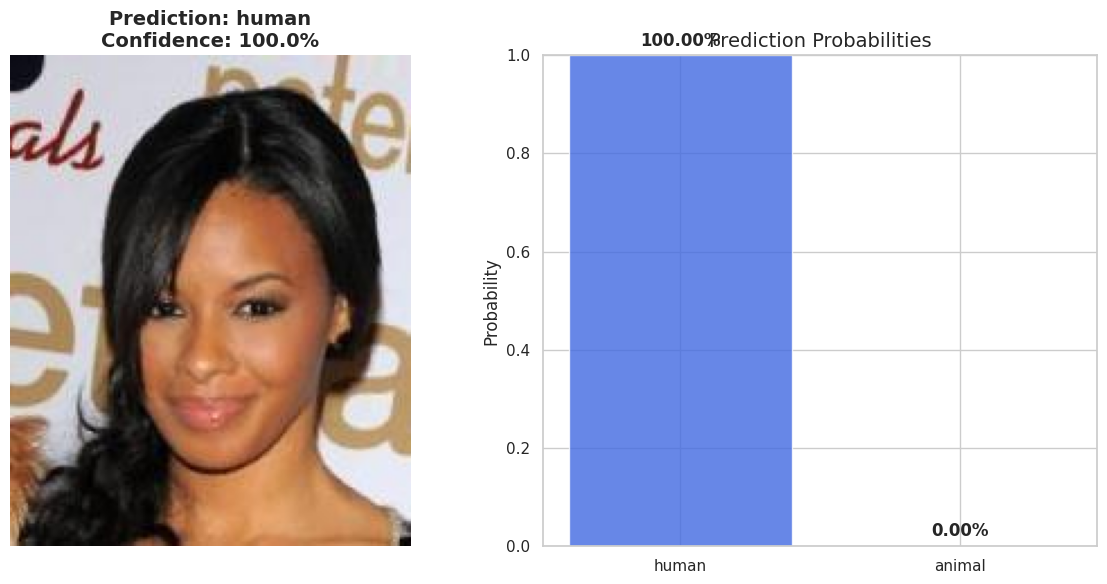

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = '/home/locutus/Downloads/CNN_Project_Group_17/dataset/single_prediction/human_or_animal_2.jpg'
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize if not already normalized

# Make a prediction
result = cnn.predict(img_array)

# For binary classification using a sigmoid output:
human_prob = result[0][0]
animal_prob = 1 - human_prob

# Determine prediction and confidence
prediction = 'human' if human_prob >= 0.5 else 'animal'
confidence = human_prob if human_prob >= 0.5 else animal_prob
confidence_percent = round(confidence * 100, 2)

# Create a figure with two subplots: one for the image and one for a bar chart of probabilities
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: Display the image with prediction label and confidence
axs[0].imshow(image.load_img(img_path))
axs[0].axis('off')
axs[0].set_title(f'Prediction: {prediction}\nConfidence: {confidence_percent}%',
                 fontsize=14, fontweight='bold')

# Right subplot: Bar chart of predicted probabilities for each class
classes = ['human', 'animal']
probs = [human_prob, animal_prob]
colors = ['royalblue', 'firebrick']

bars = axs[1].bar(classes, probs, color=colors, alpha=0.8)
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Probability', fontsize=12)
axs[1].set_title('Prediction Probabilities', fontsize=14)

# Annotate each bar with the corresponding percentage
for bar, prob in zip(bars, probs):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prob*100:.2f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('Improved_Prediction_Human.png', format='png')
plt.show()



In [36]:
print(prediction)

human


Print misclassified images from validation

138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Total Misclassified: 41


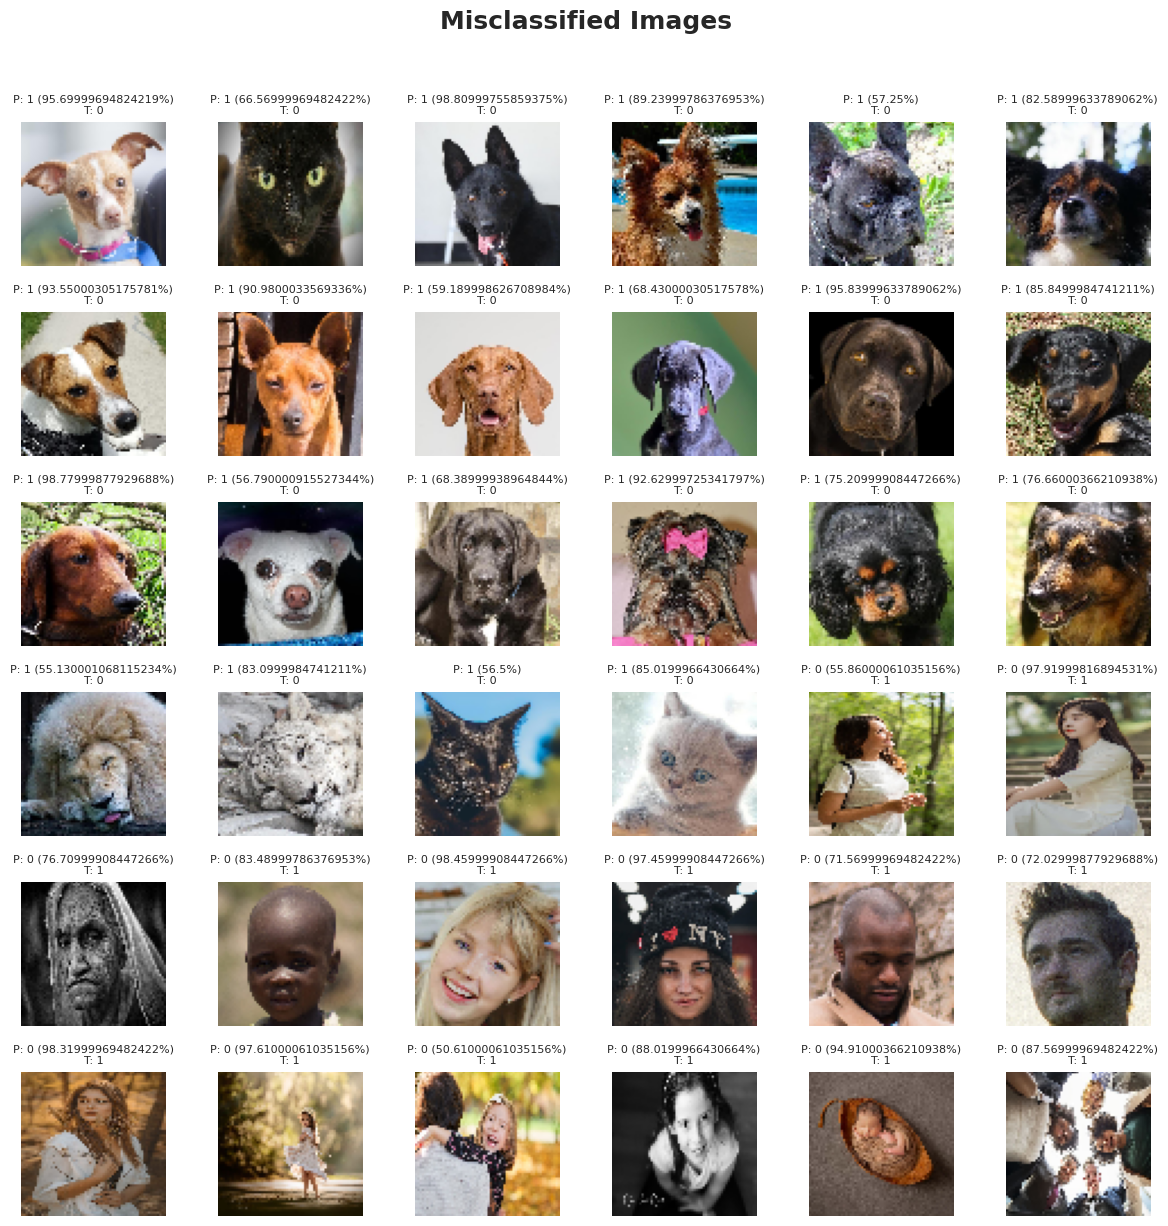

Saved 41 misclassified images to misclassified_images/


In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Ensure test_set is initialized with shuffle=False
y_true = test_set.classes

# Get the predicted probabilities from the model
y_pred_prob = cnn.predict(test_set, batch_size=32)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Get filenames of test images (ensures correct image-label mapping)
filenames = test_set.filenames

# Identify misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total Misclassified: {len(misclassified_indices)}")

# Extract misclassified filenames and labels
misclassified_files = [filenames[i] for i in misclassified_indices]
misclassified_true_labels = [y_true[i] for i in misclassified_indices]
misclassified_pred_labels = [y_pred[i] for i in misclassified_indices]

# Calculate misclassification confidence for each misclassified image
misclassified_confidences = []
for idx in misclassified_indices:
    # For binary classification with sigmoid:
    # If predicted as 1 then confidence is probability of class 1; otherwise, it's 1 - probability.
    if y_pred[idx] == 1:
         confidence = y_pred_prob[idx][0]
    else:
         confidence = 1 - y_pred_prob[idx][0]
    misclassified_confidences.append(round(confidence * 100, 2))

# Set number of misclassified images to display (up to 36)
num_display = min(36, len(misclassified_indices))

# Create a grid plot of misclassified images
plt.figure(figsize=(12, 12))
plt.suptitle('Misclassified Images', fontsize=18, fontweight='bold', y=1.02)

for i in range(num_display):
    img_path = os.path.join(test_dir, misclassified_files[i])
    img = load_img(img_path, target_size=(64, 64))

    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    # Annotate each image with predicted label (P), confidence, and true label (T)
    plt.title(f"P: {misclassified_pred_labels[i]} ({misclassified_confidences[i]}%)\nT: {misclassified_true_labels[i]}",
              fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig('Improved_Misclassifications.png', format='png', bbox_inches='tight')
plt.show()

# Save misclassified images to a separate folder for further review
save_path = "misclassified_images"
os.makedirs(save_path, exist_ok=True)

for i, img_name in enumerate(misclassified_files):
    img_path = os.path.join(test_dir, img_name)
    img = load_img(img_path, target_size=(64, 64))
    img.save(os.path.join(save_path, f"misclassified_{i}.png"))

print(f"Saved {len(misclassified_files)} misclassified images to {save_path}/")

